<a href="https://colab.research.google.com/github/Simaniyeva/Hand-Finger-Gesture-Recognition/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hand-Finger Gesture Recognition**
This project focuses on distinguishing numbers represented by hand gestures using deep learning techniques for image classification tasks.


# Structure
The notebook is organized as follow:

1. Structure
2. Introduction
3. Importing libraries
4. Data analysis
5. Loading the data for preprocessing
6. Data preprocessing
7. Data Augmentation
8. Loading dataset for modelling
9. Training

# **Introduction**
In this project, I explore various preprocessing techniques, including morphological transformations, and delve into data augmentation using data generators to enhance diversity of training dataset. I will build and analyze different network architectures through experiments, perform hypermeter tuning for optimal model performance, and implement a mechanism to store the best model on disk.



# Importing libraries

I import the necessary libraries to perform


In [ ]:
!pip install opencv-python matplotlib
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import PIL
import glob
from concurrent.futures import ThreadPoolExecutor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation,BatchNormalization
from skimage import io
from PIL import Image
import shutil
import random
import albumentations as A
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening, disk
from skimage.util import montage


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive'

/content/drive/MyDrive


# Dataset Preparation: Frame Extraction from Video
To create a dataset for training my model, I extracted individual frames from videos. Each video corresponds to a specific digit (0, 1, ..., 9), and the extracted frames are saved in subfolders based on the digit class.

This step ensures a sufficient number of labeled images for training while preserving the context of the dataset creation process.

After running this code, I successfully extracted frames and stored them in organized subfolders.

Frames for digit 0 are stored in /test/0.
Frames for other digits will follow the same approach, ensuring a **well-organized dataset**.

In [ ]:
digits = [1, 2, 3, 4, 5, 6, 7, 8, 9]
for digit in digits:
  vidcap = cv2.VideoCapture(f'/content/drive/MyDrive/Project/HandFingers/{digit}.mp4')
  folder=f'/content/drive/MyDrive/Project/HandFingers/test/{digit}'

  if not os.path.exists(folder):
      os.makedirs(folder)
  count = 0
  while True:
      success,image = vidcap.read()
      if not success:
          break
      cv2.imwrite(os.path.join(folder,f"frame{count}.jpg".format(count)), image)
      count += 1
  print(f"{count} images for digit {digit} are extracted in {folder}.")

0 images for digit 1 are extracted in /content/drive/MyDrive/Project/HandFingers/test/1.
0 images for digit 2 are extracted in /content/drive/MyDrive/Project/HandFingers/test/2.
0 images for digit 3 are extracted in /content/drive/MyDrive/Project/HandFingers/test/3.
0 images for digit 4 are extracted in /content/drive/MyDrive/Project/HandFingers/test/4.
0 images for digit 5 are extracted in /content/drive/MyDrive/Project/HandFingers/test/5.
0 images for digit 6 are extracted in /content/drive/MyDrive/Project/HandFingers/test/6.
0 images for digit 7 are extracted in /content/drive/MyDrive/Project/HandFingers/test/7.
0 images for digit 8 are extracted in /content/drive/MyDrive/Project/HandFingers/test/8.
0 images for digit 9 are extracted in /content/drive/MyDrive/Project/HandFingers/test/9.


In [ ]:
list_0=os.listdir('/content/drive/MyDrive/Project/HandFingers/0')
print(len(list_0))

282


# Loading the data for Image Augmentation & Preprocessing

In the following section, you'll look at some common image preprocessing techniques.

In [ ]:
data_dir="/content/drive/MyDrive/Project/HandFingers/"

In [ ]:
data_dir=pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/Project/HandFingers')

This code calculates the total number of images in the dataset. It does this by iterating through all the subdirectories within ```data_dir```, where each subdirectory represents a class label, and counting all the files with the ```.jpg``` extension. The ```'*/*.jpg'``` pattern ensures that it looks for ```.jpg``` files inside all the subdirectories of the main dataset folder. The function ```len()``` is then used to get the total number of such images.

In [ ]:
total_images=len(list(data_dir.glob('*/*.jpg')))
print(total_images)

3685


In [ ]:
number_one=list(data_dir.glob('1/*.jpg'))
number_one[:5]

[PosixPath('/content/drive/MyDrive/Project/HandFingers/1/frame3.jpg'),
 PosixPath('/content/drive/MyDrive/Project/HandFingers/1/frame0.jpg'),
 PosixPath('/content/drive/MyDrive/Project/HandFingers/1/frame4.jpg'),
 PosixPath('/content/drive/MyDrive/Project/HandFingers/1/frame1.jpg'),
 PosixPath('/content/drive/MyDrive/Project/HandFingers/1/frame2.jpg')]

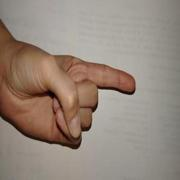

In [ ]:
PIL.Image.open(str(number_one[1])) #acccess an individual file

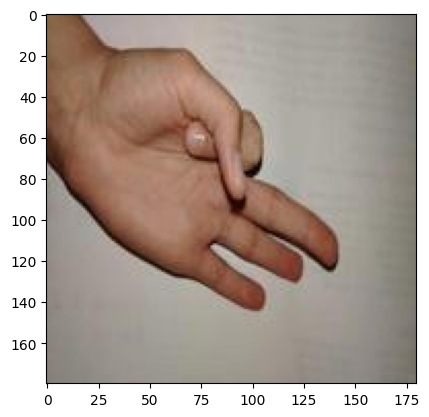

In [ ]:
rand_index = random.randint(0, total_images-1)
image_path=list(data_dir.glob('*/*.jpg'))[rand_index]
image = io.imread(str(image_path))
plt.imshow(image)
plt.show()

In [ ]:
print(image.shape)

(180, 180, 3)


Text(0.5, 0.98, 'Different Channels of Image')

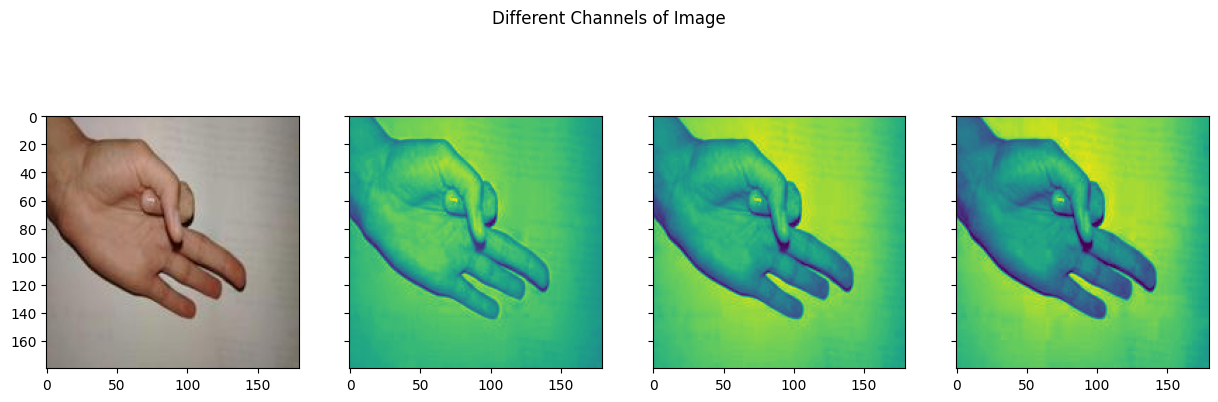

In [ ]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(15)
ax1.imshow(image)

# RGB channels
ax2.imshow(image[:, : , 0])
ax3.imshow(image[:, : , 1])
ax4.imshow(image[:, : , 2])
f.suptitle('Different Channels of Image')

#Morphological Transformations
Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.

There are a few things that stand out to me when looking at the images.

**Background complexity:** In many cases, the background contains a design, which makes it difficult for hand tracking. A plain background is more appropriate.

**The lighting** is adequate, but uneven lighting can make the edges of the hand less noticeable.

The hand is in the center of the image, which is good, but cropping out the edges of the image would have made the hand gesture more noticeable. This could have improved the model's performance.

# Erosion, Dilation, Opening & Closing

**Erosion** shrinks bright regions and enlarges dark regions.

**Dilation** on the other hand is exact opposite side - it shrinks dark regions and enlarges the bright regions

**Closing** is dilation followed by erosion. Closing can remove small dark spots and connect small bright cracks.

**Opening** is erosion followed by dilation. Opening can remove small bright spots and connect small dark cracks.

All these can be done using the ```skimage.morphology``` module. Utilities that operate on shapes in images.

These operations are particularly suited for binary images, although some may be useful for images of other types as well.
I am going to use ```.disk()```.Using a circular disk of a spesific size (3) that moves across the image to perform these morphological transformations.


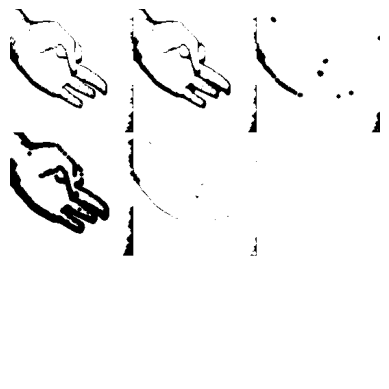

In [ ]:
bin_image = image[:, :, 0] > 125
st_element = disk(3)

# opening and closing
open_img = binary_opening(bin_image, st_element)
close_img = binary_closing(bin_image, st_element)

# erosion and dilation
eroded_img = binary_erosion(bin_image, st_element)
dilated_img = binary_dilation(bin_image, st_element)

# Create the montage
montage_image = montage([bin_image, open_img, close_img, eroded_img, dilated_img])

# Display the montage using matplotlib with the desired colormap
plt.imshow(montage_image, cmap='gray')
plt.axis('off')
plt.show()

# Data Augmentation

Apply transformations like rotations, flips, zooms, etc. using ImageDataGenerator or other augmentation libraries.
I use Albumentations library for my augmenation process.
Albumentations is a fast and flexible image augmentation library. The library is widely used in industry, deep learning research, machine learning competitions, and open source projects.

This library provides wide range of augmentations that are easy to configure and simpler than Keras.ImageDataGenerator.
In ImageDataGenerator, we have limited to predefined options(rotation, zoom, flip), but they lack custom augmentations. It is optimized for speed.

In [ ]:
transform = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.Transpose(),
    A.GaussNoise(),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.RandomBrightnessContrast(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
])

# Function to visualize images
def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)
    plt.show()

dataset_path = "/content/drive/MyDrive/Project/HandFingers/"
output_path = "/content/drive/MyDrive/Project/HandFingers/augmented_images"
os.makedirs(output_path, exist_ok=True)


image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

def augment_dataset(dataset_path, transform, output_path):
   for subfolder in os.listdir(dataset_path):
     if subfolder.isdigit():
      subfolder_path = os.path.join(dataset_path, subfolder)
      output_subfolder = os.path.join(output_path, subfolder)
      os.makedirs(output_subfolder, exist_ok=True)

      for img_name in os.listdir(subfolder_path):
        if not any(img_name.lower().endswith(ext) for ext in image_extensions):
          print(f"Skipping unimage file/directory: {img_name}")
          continue
        img_path = os.path.join(subfolder_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
          print(f"Could not load image: {img_name}")
          continue
        # Convert BGR to RGB for visualization purposes
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        augmented = transform(image=image)
        augmented_image = augmented['image']

        output_img_path = os.path.join(output_subfolder, f"aug_{img_name}")
        augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_img_path, augmented_image_bgr)
        print(f"Augmented images saved in {output_path}")

augment_dataset(dataset_path, transform, output_path)

Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Project/HandFingers/augmented_images
Augmented images saved in /content/drive/MyDrive/Proje

```RandomRotate90```-Randomly rotate the input by 90 degrees zero or more times. Making the model robust to rotational variations.

```A.HorizontalFlip``` controls the probability of applying the augmentation. p=0.5 means that with a probability of 50%, the transform will flip the image horizontally. Ensures the model recognizes hands in flipped orientations.

```Transpose``` the input by swapping its rows and columns.

```GaussNoise```-Apply Gaussian noise to the input image. Adds noise to make the model robust to environmental noise.

```Blur```-Apply uniform box blur to the input image using a randomly sized square kernel.

```CLAHE```-Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to the input image.Enhances contrast, making details more visible.

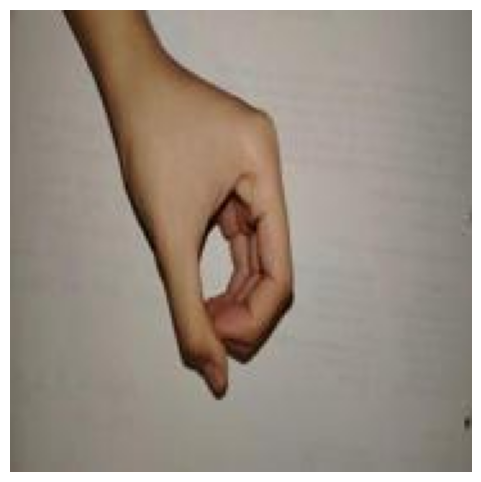

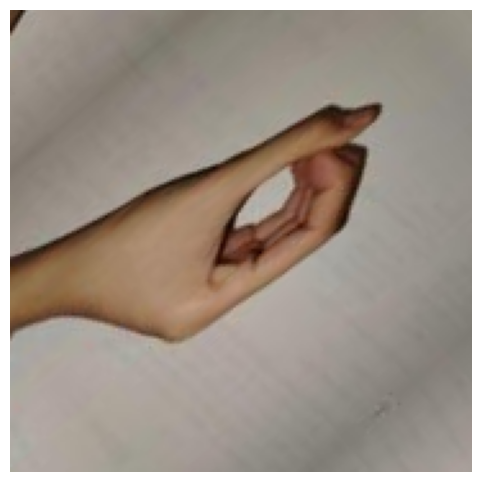

In [ ]:
img_path='/content/drive/MyDrive/Project/HandFingers/0/frame0.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
augmented = transform(image=img)
augmented_img = augmented['image']

visualize(img)
visualize(augmented_img)



# Resizing images

In [ ]:
folder_path='/content/drive/MyDrive/Project/HandFingers/augmented_images'
subfolders_name=[str(i) for i in range(10)]

width=180
height=180
def resize_with_pillow():
  resized_images=[]
  for subfolder in subfolders_name:
    subfolder_path=os.path.join(folder_path,subfolder)
    for filename in os.listdir(subfolder_path):
      if filename.endswith(('.jpg','.png','.jpeg','.gif')):
        image_path=os.path.join(subfolder_path,filename)
        img=Image.open(image_path)
        resized_image=img.resize((width,height))
        resized_images.append(resized_image)
        resized_image.save(image_path)
        img.close()
  return resized_images


In [ ]:
resized_dataset=resize_with_pillow()

Iterates through subfolders(0-9) in folder_path
For each image in the subfolders, it:

*   Loads the image.
*   Resizes it to 180x180 using PIL (Python Imaging Library)

*   Saves the resized image back to its original path.
*   Stores the resized image in a list for future use.










# Normalization

Normalization is the most crucial step in the pre-processing part. There are multiple ways to normalise images.
 Normalization technique where you divide pixel values by 255, which just lowers the range from 0-255 to 0-1, but the spread of pixel values over the range is kept the same. Normalization is mostly used when we want to have an abounding range for features, however, RGB has already an abounding system of 0-255. However, theoretically, this would still help to fasten the training process.

**Normalization: normalized_value=(raw_value-min)/(max-min)**

In [ ]:
def normalize_image(image):
  image=np.array(image).astype('float32')
  image/=255.0 #Normalize to [0,1]
  return image

def load_and_normalize_dataset(dataset):
    normalized_imgs = []
    for image in dataset:
        normalized_image = normalize_image(image)
        normalized_imgs.append(normalized_image)
    return np.array(normalized_imgs)

In [ ]:
normalized_dataset = load_and_normalize_dataset(resized_dataset)
print(normalized_dataset.shape) # Checking the shape of the normalized dataset

(2273, 180, 180, 3)


**2273**- represents the total number of images loaded from dataset.

**180, 180-** size of images. I previously resized images to 180x180 pixels using resize_with_pillow() function, so this aligns with that.

**3**-This indicates the number of channels in images, which is 3 for RGB images.

In [ ]:
# This code is no longer needed as the data has already been preprocessed and stored in normalized_dataset.
# However, it is kept for reference to how the data was originally loaded and labeled.

# handfingers_images_dict={
#     '0':list(data_dir.glob('0/*.jpg')),
#     '1':list(data_dir.glob('1/*.jpg')),
#     '2':list(data_dir.glob('2/*.jpg')),
#     '3':list(data_dir.glob('3/*.jpg')),
#     '4':list(data_dir.glob('4/*.jpg')),
#     '5':list(data_dir.glob('5/*.jpg')),
#     '6':list(data_dir.glob('6/*.jpg')),
#     '7':list(data_dir.glob('7/*.jpg')),
#     '8':list(data_dir.glob('8/*.jpg')),
#     '9':list(data_dir.glob('9/*.jpg')),
# }
# handfingers_labels_dict={
#     '0':0,
#     '1':1,
#     '2':2,
#     '3':3,
#     '4':4,
#     '5':5,
#     '6':6,
#     '7':7,
#     '8':8,
#     '9':9
#     }

Ensures all images are of a consistent size for processing and input to the model.
Makes augmentation more efficient and prevents issues like cropping/stretching augmentations applied on varying-sized images.

# Data Splitting


In [ ]:
X, y = [], []
for label in subfolders_name:
    subfolder_path = os.path.join(folder_path, label)
    for filename in os.listdir(subfolder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_path = os.path.join(subfolder_path, filename)
            img = Image.open(image_path)
            img_array = normalize_image(img)
            X.append(img_array)
            y.append(int(label))
            img.close()

X = np.array(X)
y = np.array(y)
print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

Dataset shape: (2273, 180, 180, 3), Labels shape: (2273,)


In [ ]:
X=X/255.0
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,shuffle=True, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Train set: (1591, 180, 180, 3), Validation set: (341, 180, 180, 3), Test set: (341, 180, 180, 3)


Before training the model, it is essential to preprocess the input images to ensure they are in a format suitable for the neural network. One crucial step is normalization. Neural networks perform better when input features have similar scales, which helps avoid issues like vanishing gradients.

For this project, the image pixel values were normalized to the range [0, 1].

In [ ]:
print(X_train.min(), X_train.max())

0.0 0.003921569


There are several reasons why I use CNN instead of other networks.
CNN is smaller and simpler than others. It makes it easier for me to apply to my dataset.
Considering my small dataset, I thought it was pointless to use a complex network.
Here I have control over the processes and architecture such as adding layers, adjusting the filter size, etc.

# Building the Model

In [ ]:
SIZE=180
INPUT_SHAPE=(SIZE,SIZE,3)
BATCH_SIZE=32
model=Sequential()

model.add(Conv2D(64,(3,3),input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 178, 178, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 87, 87, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 43, 43, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 43, 43, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 43, 43, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 112896)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,450,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,823,946 (56.55 MB)

 Trainable params: 14,823,434 (56.55 MB)

 Non-trainable params: 512 (2.00 KB)

None


I made some changes to the layers in the model;change dropout rate and re-fitted it, and this is how I got the best version of accuracy.

In [ ]:
history=model.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    steps_per_epoch=len(X_train)//BATCH_SIZE,
    validation_steps=len(X_val)//BATCH_SIZE,
    validation_data=(X_val,y_val)
)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 381s 8s/step - accuracy: 0.1233 - loss: 2.2962 - val_accuracy: 0.0792 - val_loss: 2.3009
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 403s 7s/step - accuracy: 0.2911 - loss: 2.1115 - val_accuracy: 0.0792 - val_loss: 2.2817
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.4934 - loss: 1.5816 - val_accuracy: 0.2258 - val_loss: 2.2318
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 363s 7s/step - accuracy: 0.6047 - loss: 1.2958 - val_accuracy: 0.4135 - val_loss: 2.1711
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.6798 - loss: 1.0638 - val_accuracy: 0.3548 - val_loss: 2.1333
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7741 - loss: 1.6218
Test Loss: 1.6152
Test Accuracy: 0.7537


In [ ]:
model.save('/content/drive/MyDrive/final_model.h5')


In [ ]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Compare with true test labels
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Test Accuracy: {accuracy}")


NameError: name 'model' is not defined

              precision    recall  f1-score   support

           0       0.95      0.81      0.88        43
           1       0.82      0.76      0.79        55
           2       0.80      0.62      0.70        39
           3       0.68      0.84      0.75        31
           4       0.70      0.67      0.68        39
           5       0.59      0.84      0.69        31
           6       0.91      0.70      0.79        30
           7       0.67      0.93      0.78        15
           8       0.60      0.80      0.69        30
           9       0.85      0.61      0.71        28

    accuracy                           0.75       341
   macro avg       0.76      0.76      0.75       341
weighted avg       0.77      0.75      0.75       341



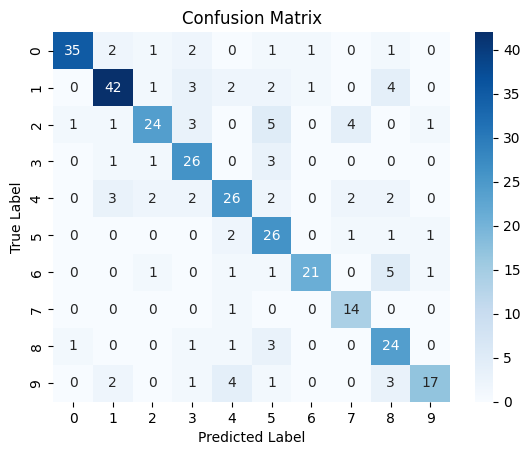

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print(classification_report(y_test, predicted_classes))

# Confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


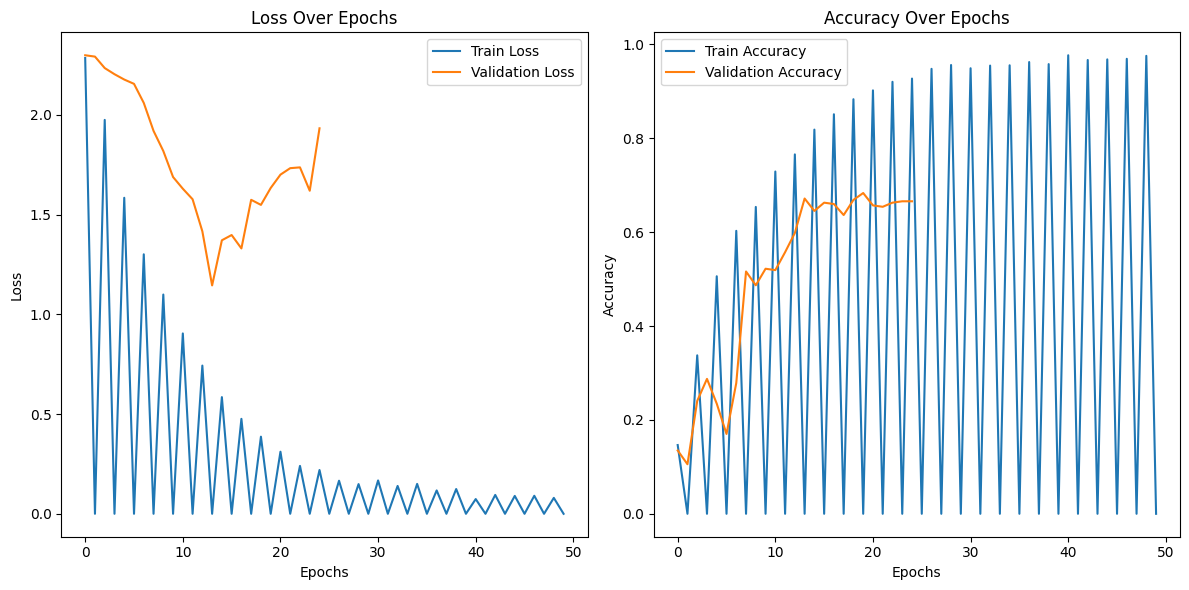

In [ ]:
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!zip -r HandFingers_dataset.zip /content/drive/MyDrive/Project/HandFingers


Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/Project/HandFingers/5/frame2.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame5.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame4.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame9.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame7.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame8.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame13.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame11.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame10.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame6.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame15.jpg (deflated 3%)
  adding: content/drive/MyDrive/Project/HandFingers/5/frame18.jpg (deflated 

In [ ]:
from google.colab import files
files.download("HandFingers_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>